In [1]:
%load_ext autoreload
%autoreload 2

import tracemalloc
from collections import Counter
import linecache
import os

def display_top(snapshot, key_type='lineno', limit=3):
    snapshot = snapshot.filter_traces((
        tracemalloc.Filter(False, "<frozen importlib._bootstrap>"),
        tracemalloc.Filter(False, "<unknown>"),
    ))
    top_stats = snapshot.statistics(key_type)

    print("Top %s lines" % limit)
    for index, stat in enumerate(top_stats[:limit], 1):
        frame = stat.traceback[0]
        # replace "/path/to/module/file.py" with "module/file.py"
        filename = os.sep.join(frame.filename.split(os.sep)[-2:])
        print("#%s: %s:%s: %.1f KiB"
              % (index, filename, frame.lineno, stat.size / 1024))
        line = linecache.getline(frame.filename, frame.lineno).strip()
        if line:
            print('    %s' % line)

    other = top_stats[limit:]
    if other:
        size = sum(stat.size for stat in other)
        print("%s other: %.1f KiB" % (len(other), size / 1024))
    total = sum(stat.size for stat in top_stats)
    print("Total allocated size: %.1f KiB" % (total / 1024))

tracemalloc.start()


In [2]:
from utils_v1 import *


In [3]:
from icecream import ic

import numpy as np
from src.dataset import (
    MultipleDates,
    PA, PADeforestationTime, PADistanceMap, PAMultipleDates,
    MTDeforestationTime,
    MTMultipleDates
)

# from src.dataset_legacy import MTDeforestationTime
from src import training_generator as generator
from src.patchesHandler import PatchesHandler, PatchesHandlerMultipleDates, PatchesHandlerEvidential

from src.trainer.evidential import TrainerEvidential, TrainerEvidentialUEO
import src.trainer.evidential as evidential

from mpl_toolkits.axes_grid1 import make_axes_locatable

import cv2
from src import metrics as _metric
from src.backend.Logger import Logger


In [4]:
from enum import Enum
UncertaintyMethod = Enum('Predictor', 'pred_var MI pred_entropy KL pred_entropy_single evidential')
uncertaintyMethod = "evidential"


In [5]:

config = {
	"training": False,
	"learning_rate": 1e-4, # 1e-3
	"weights": [0.1, 0.9, 0],
	"save_probabilities": False,
	"loadInference": False,
	"addPastDeforestationInput": True,
	"inference_times": 1,
	"Uncertainty": {
		"annealing_step": 10*375 # 1875, 10*375*10
	},
	"uncertainty_method": uncertaintyMethod,
	"evidence_function": evidential.relu_evidence,
#	"loss": evidential.loss_evidential_dice
}

# config["loss"] = config["loss"](config["weights"])
'''
if config["training"] == True:
	dates = [2017, 2018]
else:
	dates = [2018, 2019]
if config["training"] == True:
	dates = [2018, 2019]
else:
	dates = [2019, 2020]
'''
site = 'PA'
if site == 'PA':
	dates = [2018, 2019]
	# dates = [2017, 2018]

	dataset = PAMultipleDates(dates = dates, # dates = [2017, 2018, 2019]. [2018, 2019]. [2015, 2016, 2017, 2018]
		addPastDeforestationInput = config['addPastDeforestationInput'],
		borderBuffer = 2)	
elif site == 'MT':
	dates = [2019, 2020]
	dataset = MTMultipleDates(dates = dates, # dates = [2016,2017,2018,2019]
		addPastDeforestationInput = config['addPastDeforestationInput'],
		borderBuffer = 2)	
# dataset = MTDeforestationTime()	
# [2016, 2017, 2018]

ic(dates)


if issubclass(type(dataset), MultipleDates):
	patchesHandler = PatchesHandlerEvidential(
		dataset)
else:
	patchesHandler = PatchesHandler()

# exp = 170
# exp = 155
exp = 155 # relu
# exp = 171 # softsign
## exp = 173
exp = 191
exp = 192
exp = 195
exp = 197

# if config["training"] == True:
# trainer = TrainerEvidentialUEO(config, dataset, patchesHandler)
logger = Logger()
trainer = TrainerEvidential(config, dataset, patchesHandler, logger)

trainer.defineExperiment(exp)


ic| list(self.date_ids): [0]
ic| self.image_channels: [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]]
ic| dates: [2018, 2019]
ic| self.input_image_shape: 21
ic| self.dataset.image_channels: [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]]


In [6]:
exp

196

In [7]:
trainer.setExperimentPath()
trainer.createLogFolders()

In [8]:
# ic(type(dataset), exp, dataset.dates)


In [9]:

trainer.loadLabel()

D:/Jorge/datasets/deforestation/Para/deforestation_past_years.tif
Loaded deforestation past years


ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([132185553,   3150503,   4571354,    864429,    903608,   1299506,
                                                                      2477971,   1561686,   1459696,    969060,    644976,   2209014,
                                                                      2100204,   5257014,   3514616], dtype=int64))


Label where deforestation past years is actual date (2019) = 1


ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([132185553,   3150503,   4571354,    864429,    903608,   1299506,
                                                                      2477971,   1561686,   1459696,    969060,    644976,   2209014,
                                                                      2100204,   5257014,   3514616], dtype=int64))


Past deforestation different from 0 (no deforestation)


ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([132185553,   3150503,   4571354,    864429,    903608,   1299506,
                                                                      2477971,   1561686,   1459696,    969060,    644976,   2209014,
                                                                      2100204,   5257014,   3514616], dtype=int64))


Past deforestation before 2008 is 2
D:/Jorge/datasets/deforestation/deforestation_before_2008/deforestation_before_2008_para.tif


ic| np.unique(label_past_deforestation_before_2008, return_counts=True): (array([  0, 215], dtype=uint8), array([124211220,  38957970], dtype=int64))
ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([132185553,   3150503,   4571354,    864429,    903608,   1299506,
                                                                      2477971,   1561686,   1459696,    969060,    644976,   2209014,
                                                                      2100204,   5257014,   3514616], dtype=int64))
ic| label_per_date.shape: (17730, 9203, 1)


Removing bufer................
Mask label shape:  
 (17730, 9203, 1) 
 Unique values:  
 [0 1 2]


In [10]:

# Creating tile mask
trainer.createTrainValTestTiles()


Tiles size:  3546 2300
Mask size:  (17730, 9200)


In [11]:

trainer.label_mask.dtype

dtype('uint8')

In [12]:

trainer.getLabelCurrentDeforestation()

In [13]:

trainer.loadInputImage()

ic| image_stack.shape: (17730, 9203, 21)


Image shape:  (17730, 9203, 21)
mask:  (17730, 9200)
image stack:  (17730, 9200, 21)
ref : (17730, 9200, 1)


In [14]:

np.unique(trainer.image_stack[...,0], return_counts=True)

(array([0.        , 0.08333334, 0.16666667, 0.25      , 0.33333334,
        0.4166667 , 0.5       , 0.5833334 , 0.6666667 , 0.75      ,
        0.8333334 , 0.9166667 , 1.        ], dtype=float32),
 array([104050616,   2209014,    644713,    968315,   1458862,   1560879,
          2477424,   1299508,    903419,    864429,   4570932,   3150455,
         38957434], dtype=int64))

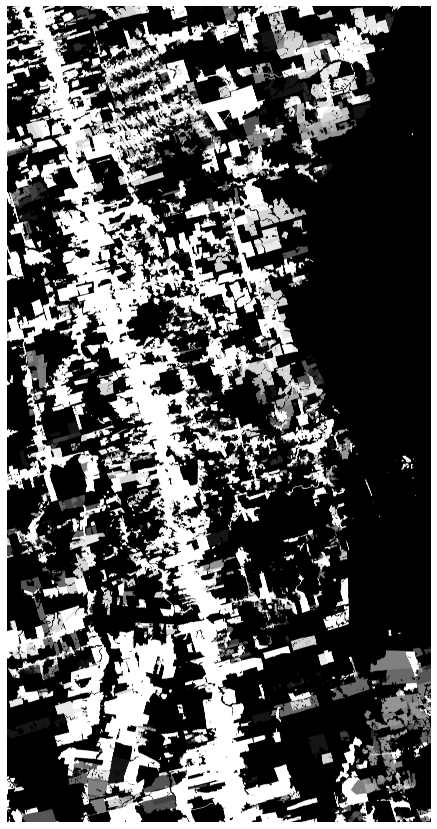

In [15]:

trainer.logger.plotFigure(trainer.image_stack[...,0], 
    name='image_stack_first_channel', cmap=plt.cm.gray, savefig=False)

In [16]:

trainer.getImageChannels()

ic| self.image_stack.shape: (17730, 9200, 21)
ic| self.channels: 21


In [17]:

trainer.getTrainValTestMasks()

Training tiles:  [1, 3, 5, 8, 11, 13, 14, 20]
Validation tiles:  [6, 19]
Test tiles:  [2, 4, 7, 9, 10, 12, 15, 16, 17, 18]


In [18]:

if config["training"] == True:
    # Extracting patches from the idx matrix
    trainer.createIdxImage()


ic| im_idx_row.shape: (17730, 9200, 1)
    im_idx_col.shape: (17730, 9200, 1)
ic| im_idx_row.dtype: dtype('uint16')
    im_idx_col.dtype: dtype('uint16')
ic| im_idx.shape: (17730, 9200, 2), im_idx.dtype: dtype('uint16')


In [19]:
if config["training"] == True:
    trainer.extractCoords()

ic| coords.shape: (464, 239, 1, 128, 128, 2)
    coords.dtype: dtype('uint16')
ic| coords.shape: (110896, 2), coords.dtype: dtype('uint16')


In [20]:
if config["training"] == True:
    trainer.trainTestSplit()

ic| self.coords_train.shape: (41812, 3)
    self.coords_val.shape: (10260, 3)


In [21]:
if config["training"] == True:
    trainer.label_mask.shape

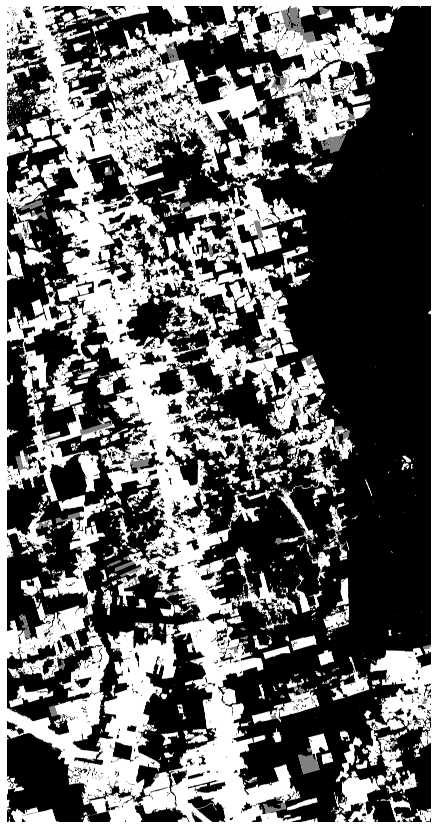

In [22]:
if config["training"] == True:
    if type(dataset) != PADeforestationTime and type(dataset) != MTDeforestationTime:
        trainer.logger.plotFigure(trainer.label_mask[...,-1], 
            name='Reference', cmap=plt.cm.gray, savefig=False)

    else:
        trainer.logger.plotFigure(trainer.label_mask[...,-1], 
            name='Reference', cmap=plt.cm.gray, savefig=False)



In [23]:
if config["training"] == True:
    np.unique(trainer.label_mask)

In [24]:
if config["training"] == True:
    print(trainer.coords_train)

[[    0     0     0]
 [    0    38     0]
 [    0    76     0]
 ...
 [17594  8968     0]
 [17594  9006     0]
 [17594  9044     0]]


In [25]:
if config["training"] == True:
    trainer.retrieveSamplesOfInterest()

training samples:  (3753, 3) validation samples:  (1032, 3)


In [26]:
if config["training"] == True:
    inputSnipShow = True

[12084  2508     0]


ic| np.mean(image_patch[...,[1,2,3]]): 0.107682176
    np.mean(image_patch[...,[11,12,13]]): 0.22637562


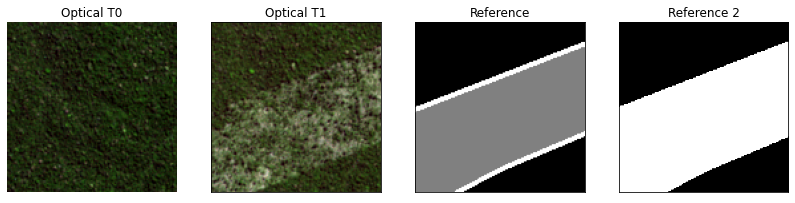

In [27]:
if config["training"] == True:
    if inputSnipShow == True:
        trainer.snipDataset(idx = 2800)


ic| np.mean(image_patch[...,[1,2,3]]): 0.2714837
    np.mean(image_patch[...,[11,12,13]]): 0.30292988
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 114 5928    0]


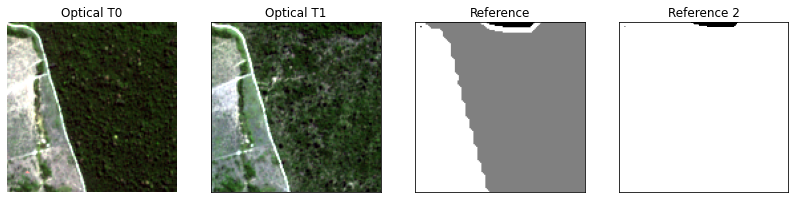

In [28]:
if config["training"] == True:
    if inputSnipShow == True:
        trainer.snipDataset(idx = 97)


ic| np.mean(image_patch[...,[1,2,3]]): 0.15096879
    np.mean(image_patch[...,[11,12,13]]): 0.103304155


[3382 2128    0]


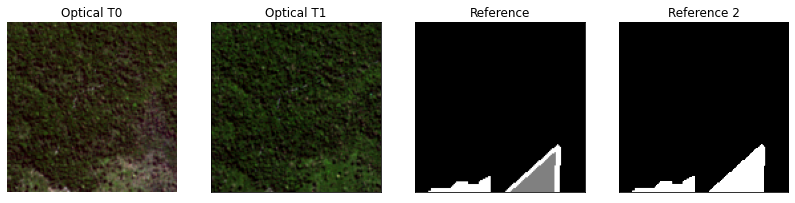

In [29]:
if config["training"] == True:
    if inputSnipShow == True:

        trainer.snipDataset(idx = 1200)

ic| np.mean(image_patch[...,[1,2,3]]): 0.09604081
    np.mean(image_patch[...,[11,12,13]]): 0.23388559


[ 608 6574    0]


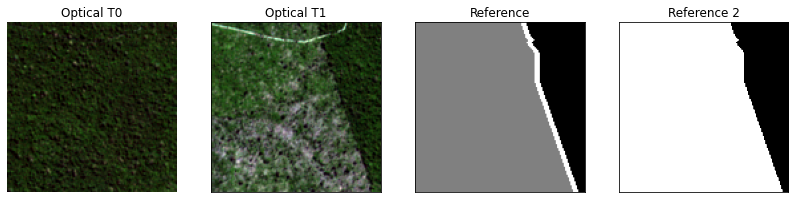

In [30]:
if config["training"] == True:
    if inputSnipShow == True:

        trainer.snipDataset(idx = 400)

In [31]:
if config["training"] == True:
    trainer.getGenerators()


In [32]:
if config["training"] == True:
    trainer.fixChannelNumber()

In [33]:
if config["training"] == True:
    print(trainer.path_exp)

D:/Jorge/datasets/deforestation/experiments/exp196


In [34]:
if config["training"] == True:
    print(trainer.channels)

21


In [35]:
if config["training"] == True:
    print(trainer.image_stack.shape)

(17730, 9200, 21)


In [36]:
# trainer.weights = [0.01, 0.99, 0]
trainer.weights

[0.1, 0.9, 0]

### Evidential metrics

In [37]:
if config["training"] == True:
    trainer.train()

time:  0


c:\Users\jchamorro\Anaconda3\envs\tf2\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_enc_net (InputLayer)      [(None, 128, 128, 21 0                                            
__________________________________________________________________________________________________
res1_net1 (Conv2D)              (None, 128, 128, 16) 3040        input_enc_net[0][0]              
__________________________________________________________________________________________________
drop_net1 (Dropout)             (None, 128, 128, 16) 0           res1_net1[0][0]                  
__________________________________________________________________________________________________
res2_net1 (Conv2D)              (None, 128, 128, 16) 2320        drop_net1[0][0]                  
______________________________________________________________________________________________

c:\Users\jchamorro\Anaconda3\envs\tf2\lib\site-packages\tensorflow\python\keras\engine\training.py:1969: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


alpha Tensor("loss/add:0", shape=(None, 128, 128, 3), dtype=float32)
u Tensor("loss/truediv:0", shape=(None, 128, 128, 1), dtype=float32)
A Tensor("loss/Sum_3:0", shape=(None, 3), dtype=float32)
B Tensor("loss/Sum_4:0", shape=(None, 1, 1, 3), dtype=float32)
term1 Tensor("loss/truediv_7:0", shape=(None, 1, 1, 3), dtype=float32)
term2 Tensor("loss/mul_5:0", shape=(None, 1, 1, 3), dtype=float32)
Tensor("loss/Repeat_1/Reshape_1:0", shape=(None, None, None, 1), dtype=float32)
alpha Tensor("add:0", shape=(None, 128, 128, 3), dtype=float32)
u Tensor("truediv:0", shape=(None, 128, 128, 1), dtype=float32)
K.int_shape(KL_reg) Tensor("mul_6:0", shape=(None, 128, 128, 1), dtype=float32)
alpha Tensor("add_7:0", shape=(None, 128, 128, 3), dtype=float32)
u Tensor("truediv_5:0", shape=(None, 128, 128, 1), dtype=float32)
K.int_shape(KL_reg) Tensor("mul_12:0", shape=(None, 128, 128, 1), dtype=float32)
alpha Tensor("add_16:0", shape=(None, 128, 128, 3), dtype=float32)
u Tensor("truediv_13:0", shape=(None

c:\Users\jchamorro\Anaconda3\envs\tf2\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/100
self.global_step 350.0
351/351 [==============================] - 32s 93ms/step - loss: 0.8399 - accuracy: 0.5491 - KL_term: 0.0170 - loglikelihood_term: 0.5555 - evidential_success: 22.8306 - evidential_fail: 4.0553 - acc: 0.5490 - annealing_coef: 0.0933 - global_step_get: 350.0000 - annealing_step_get: 3750.0000 - UEO_term: 0.8818 - val_loss: 0.8463 - val_accuracy: 0.6488 - val_KL_term: 0.0135 - val_loglikelihood_term: 0.4548 - val_evidential_success: 9.4080 - val_evidential_fail: 1.0629 - val_acc: 0.6530 - val_annealing_coef: 0.1867 - val_global_step_get: 700.0000 - val_annealing_step_get: 3750.0000 - val_UEO_term: 0.8997

Epoch 00002: val_loss improved from 0.85807 to 0.84630, saving model to D:/Jorge/datasets/deforestation/experiments/exp196/models\resunet_0.h5
Epoch 3/100
self.global_step 700.0
351/351 [==============================] - 33s 94ms/step - loss: 0.8403 - accuracy: 0.5540 - KL_term: 0.0172 - loglikelihood_term: 0.5221 - evidential_success: 28.5160 - eviden

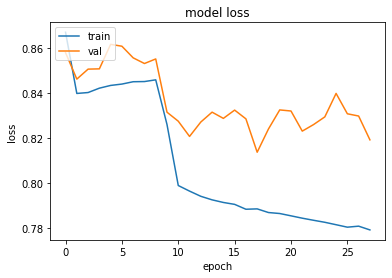

In [38]:
if config["training"] == True:
    trainer.plotHistory()


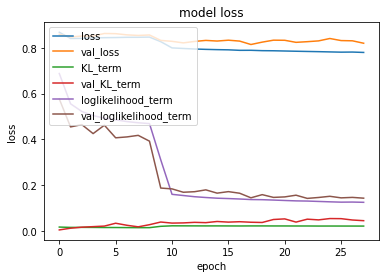

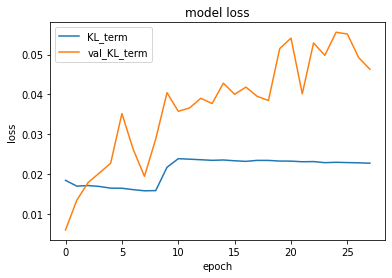

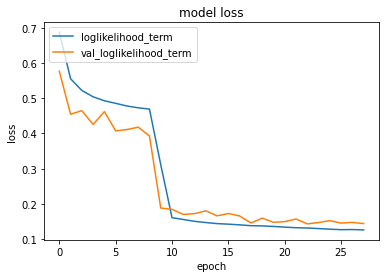

In [39]:
if config["training"] == True:
    trainer.plotLossTerms()

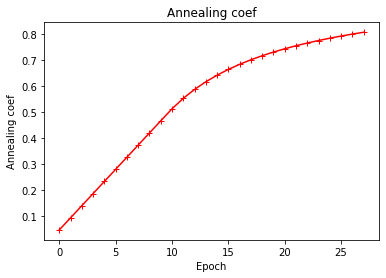

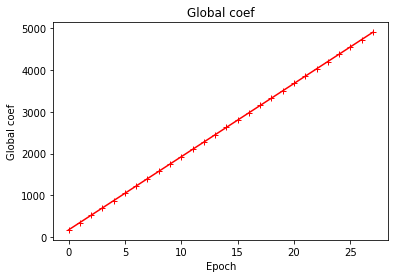

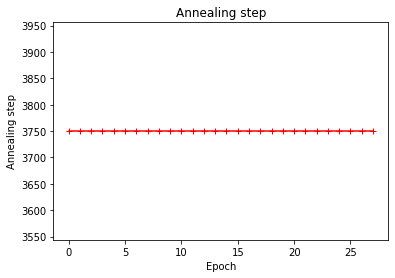

In [40]:
if config["training"] == True:
    trainer.plotAnnealingCoef()

In [41]:
def draw_EDL_results(K, history):
    # train_acc1, train_ev_s, train_ev_f, test_acc1, test_ev_s, test_ev_f 
    # calculate uncertainty for training and testing data for correctly and misclassified samples
    '''
    K: known classes
    '''
    train_u_succ = K / (K+np.array(history['evidential_success']))
    train_u_fail = K / (K+np.array(history['evidential_fail']))
    test_u_succ  = K / (K+np.array(history['val_evidential_success']))
    test_u_fail  = K / (K+np.array(history['val_evidential_fail']))
    
    f, axs = plt.subplots(2, 2)
    f.set_size_inches([10,10])
    
    axs[0,0].plot(history['evidential_success'],c='r',marker='+')
    axs[0,0].plot(history['evidential_fail'],c='k',marker='x')
    axs[0,0].set_title('Train Data')
    axs[0,0].set_xlabel('Epoch')
    axs[0,0].set_ylabel('Estimated total evidence for classification') 
    axs[0,0].legend(['Correct Clasifications','Misclasifications'])
    
    axs[0,1].plot(train_u_succ,c='r',marker='+')
    axs[0,1].plot(train_u_fail,c='k',marker='x')
    axs[0,1].plot(history['acc'],c='blue',marker='*')
    axs[0,1].set_title('Train Data')
    axs[0,1].set_xlabel('Epoch')
    axs[0,1].set_ylabel('Estimated uncertainty for classification')
    axs[0,1].legend(['Correct clasifications','Misclasifications', 'Accuracy'])
    
    axs[1,0].plot(history['val_evidential_success'],c='r',marker='+')
    axs[1,0].plot(history['val_evidential_fail'],c='k',marker='x')
    axs[1,0].set_title('Test Data')
    axs[1,0].set_xlabel('Epoch')
    axs[1,0].set_ylabel('Estimated total evidence for classification') 
    axs[1,0].legend(['Correct Clasifications','Misclasifications'])
    
    axs[1,1].plot(test_u_succ,c='r',marker='+')
    axs[1,1].plot(test_u_fail,c='k',marker='x')
    axs[1,1].plot(history['val_acc'],c='blue',marker='*')
    axs[1,1].set_title('Test Data')
    axs[1,1].set_xlabel('Epoch')
    axs[1,1].set_ylabel('Estimated uncertainty for classification')
    axs[1,1].legend(['Correct clasifications','Misclasifications', 'Accuracy'])
    

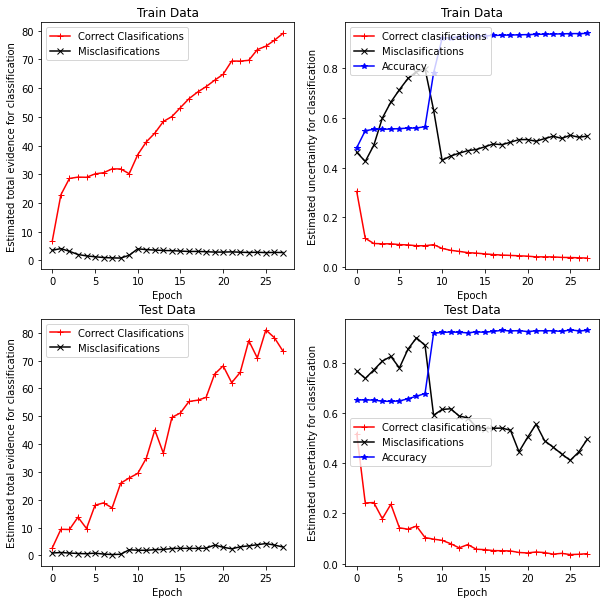

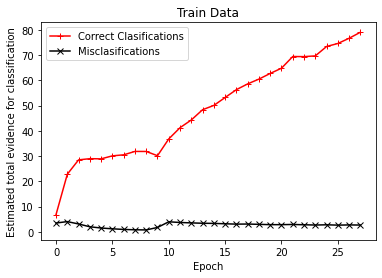

In [42]:
if config["training"] == True:
    draw_EDL_results(trainer.class_n, trainer.history.history)

    plt.figure(5)
    plt.plot(trainer.history.history['evidential_success'],c='r',marker='+')
    plt.plot(trainer.history.history['evidential_fail'],c='k',marker='x')
    plt.title('Train Data')
    plt.xlabel('Epoch')
    plt.ylabel('Estimated total evidence for classification') 
    plt.legend(['Correct Clasifications','Misclasifications'])


In [43]:
trainer.image_stack.shape

(17730, 9200, 21)

In [44]:
if type(trainer.dataset) != PADeforestationTime and type(trainer.dataset) != MTDeforestationTime:
    trainer.patchesHandler.dataset.image_channels[-1]

In [45]:
if issubclass(type(dataset), MultipleDates):
	trainer.channels = trainer.patchesHandler.input_image_shape
	trainer.image_stack = trainer.image_stack[..., trainer.patchesHandler.dataset.image_channels[-1]]
	trainer.label_mask = trainer.label_mask[...,-1]

In [46]:
trainer.image_stack.shape

(17730, 9200, 21)

In [47]:
trainer.setPadding()

-30.0 -16.0


In [48]:
trainer.infer()

ic| self.path_models+ '/' + self.method +'_'+str(0)+'.h5': 'D:/Jorge/datasets/deforestation/experiments/exp196/models/resunet_0.h5'


time:  0


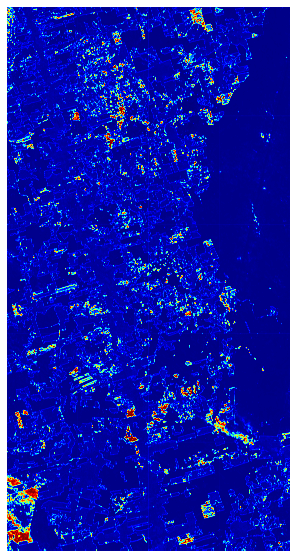

In [49]:
trainer.logger.plotFigure(trainer.u_reconstructed, 
            name='Uncertainty', cmap='jet', savefig=False, figsize=(10,10))

In [50]:
trainer.loadPredictedProbabilities()


In [51]:
trainer.prob_rec.shape

(17760, 9216)

In [52]:
trainer.getMeanProb()

In [53]:
trainer.logger.getStats(trainer.mean_prob)

ic| np.min(value): 0.0033348228
    np.mean(value): 0.032581
    np.max(value): 0.97004426


In [54]:
ic(trainer.mean_prob.shape)

ic| trainer.mean_prob.shape: (17760, 9216)


(17760, 9216)

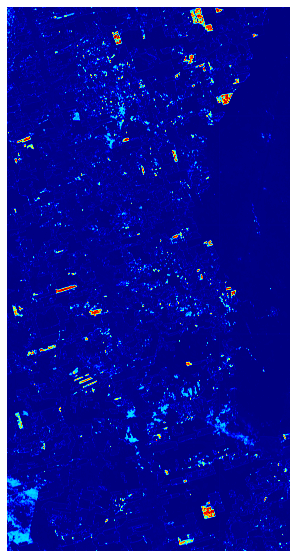

In [55]:
trainer.unpadMeanProb()
trainer.logger.plotFigure(trainer.mean_prob, 
            name='Mean predicted probability', figsize=(10,10), cmap='jet', savefig=False)

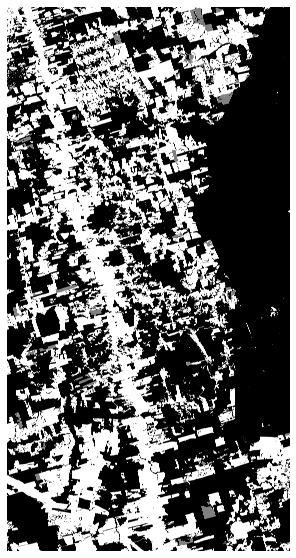

In [56]:
trainer.logger.plotFigure(trainer.label_mask, 
            name='Reference mask', figsize=(10,10), cmap=plt.cm.gray, savefig=True)

In [57]:
trainer.squeezeLabel()

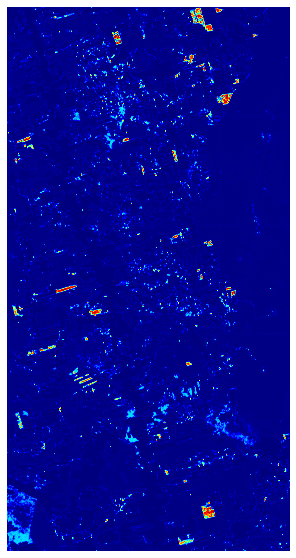

In [58]:
trainer.setMeanProbNotConsideredAreas()
trainer.logger.plotFigure(trainer.mean_prob, 
            name='Mean predicted probability', figsize=(10,10), cmap='jet', savefig=False)

In [59]:
trainer.logger.getStats(trainer.mean_prob)

ic| np.min(value): 0.0
    np.mean(value): 0.02409328
    np.max(value): 0.97004426


In [60]:
print(trainer.label_mask.shape)

(17730, 9200)


In [61]:
trainer.getLabelTest()

(54236371,)
(array([0, 1], dtype=uint8), array([53470765,   765606], dtype=int64))


In [62]:
trainer.getMAP()

78.24


In [63]:
trainer.prob_rec.shape

(17760, 9216)

In [64]:
trainer.preprocessProbRec()
print(trainer.prob_rec.shape)

(17760, 9216, 1)


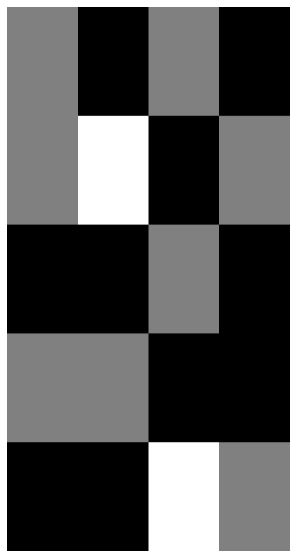

In [65]:
trainer.logger.plotFigure(trainer.mask_tr_val, 
            name=trainer.dataset.site + trainer.title_name + ' Train val mask.png', figsize=(10,10), savefig=False)

In [66]:
trainer.getLabelCurrentDeforestation()

In [67]:
trainer.applyProbabilityThreshold()

(17730, 9200)
(array([0., 1.], dtype=float32), array([161642223,   1473777], dtype=int64))


ic| self.predicted_unpad.shape: (17730, 9200)
    self.predicted.shape: (17730, 9200)


In [68]:
trainer.getTestValues()

ic| predicted_test.shape: (81558000,)
ic| predicted_test.shape: (54236371,)


In [69]:
trainer.removeSmallPolygons()

ic| np.unique(predicted, return_counts=True): (array([0., 1.], dtype=float32), array([161642223,   1473777], dtype=int64))
    np.unique(predicted_larger_than_min_area, return_counts=True): (array([0., 1.], dtype=float32), array([161875723,   1240277], dtype=int64))
ic| np.unique(ignored_polygons, return_counts=True): (array([0., 1.], dtype=float32), array([162882500,    233500], dtype=int64))


In [70]:
trainer.calculateMetrics()

ic| self.f1: 75.98, self.precision: 93.7, self.recall: 63.9


In [71]:
trainer.getValidationValuesForMetrics()
trainer.calculateMetricsValidation()

ic| self.label_mask_val.shape: (16311600,)
ic| self.label_mask_val_valid.shape: (9426356,)
ic| f1_val: 76.58
    precision_val: 89.58
    recall_val: 66.87
    mAP_val: 86.44


In [72]:
calculateMAPWithoutSmallPolygons = False
if calculateMAPWithoutSmallPolygons == True:
    trainer.calculateMAPWithoutSmallPolygons()

In [73]:
trainer.get_label_no_buffer()


D:/Jorge/datasets/deforestation/Para/deforestation_past_years.tif
Loaded deforestation past years


ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([132185553,   3150503,   4571354,    864429,    903608,   1299506,
                                                                      2477971,   1561686,   1459696,    969060,    644976,   2209014,
                                                                      2100204,   5257014,   3514616], dtype=int64))


Label where deforestation past years is actual date (2019) = 1


ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([132185553,   3150503,   4571354,    864429,    903608,   1299506,
                                                                      2477971,   1561686,   1459696,    969060,    644976,   2209014,
                                                                      2100204,   5257014,   3514616], dtype=int64))


Past deforestation different from 0 (no deforestation)


ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([132185553,   3150503,   4571354,    864429,    903608,   1299506,
                                                                      2477971,   1561686,   1459696,    969060,    644976,   2209014,
                                                                      2100204,   5257014,   3514616], dtype=int64))


Past deforestation before 2008 is 2
D:/Jorge/datasets/deforestation/deforestation_before_2008/deforestation_before_2008_para.tif


ic| np.unique(label_past_deforestation_before_2008, return_counts=True): (array([  0, 215], dtype=uint8), array([124211220,  38957970], dtype=int64))
ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([132185553,   3150503,   4571354,    864429,    903608,   1299506,
                                                                      2477971,   1561686,   1459696,    969060,    644976,   2209014,
                                                                      2100204,   5257014,   3514616], dtype=int64))
ic| label_per_date.shape: (17730, 9203, 1)


In [74]:
trainer.getErrorMask()

(array([0., 1.], dtype=float32), array([162323741,    792259], dtype=int64))


In [75]:
'''

import types

trainer.getErrorMaskToShowRGB = types.MethodType(getErrorMaskToShowRGB, trainer)
'''


'\n\nimport types\n\ntrainer.getErrorMaskToShowRGB = types.MethodType(getErrorMaskToShowRGB, trainer)\n'

In [76]:
trainer.getErrorMaskToShowRGB()

[0. 1.]


In [77]:
predicted_unpad_to_show = trainer.predicted_unpad.copy()

predicted_unpad_to_show[trainer.label_mask == 2] = 0
print(np.unique(predicted_unpad_to_show))

[0. 1.]


In [78]:
predicted_unpad_to_show.shape

(17730, 9200)

In [79]:

'''
trainer.logger.plotFigure = types.MethodType(trainer.logger.plotFigure, trainer)
'''

'\ntrainer.logger.plotFigure = types.MethodType(trainer.logger.plotFigure, trainer)\n'

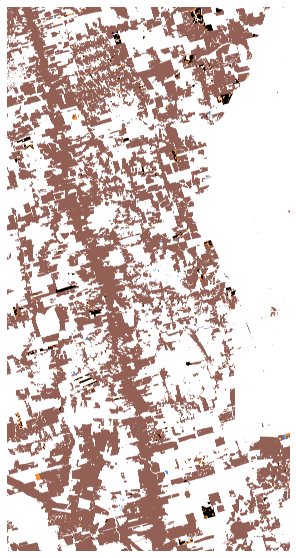

In [80]:
trainer.logger.plotFigure(trainer.error_mask_to_show_rgb[...,::-1], 
            name=trainer.dataset.site + trainer.title_name + ' error mask color.png', 
            figsize=(10,10), savefig=True, dpi=300)

In [81]:
trainer.setUncertainty()

In [82]:
trainer.getValidationValues2()
trainer.getTestValues2()

ic| self.label_mask.shape: (17730, 9200)
ic| self.mask_amazon_ts.shape: (17730, 9200)
ic| self.label_mask_test.shape: (81558000,)
ic| self.error_mask_test.shape: (54118385,)


In [83]:
trainer.getUncertaintyToShow()
trainer.logger.getStats(trainer.uncertainty_to_show)


ic| np.min(value): 0.0
    np.mean(value): 0.052946333
    np.max(value): 1.0


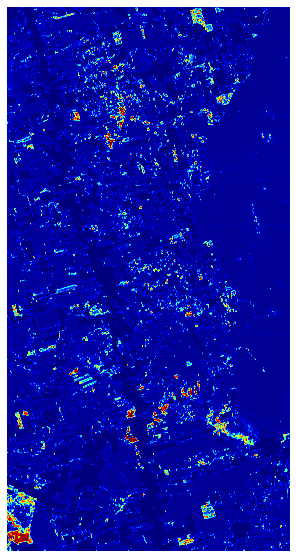

In [84]:
trainer.logger.plotFigure(trainer.uncertainty_to_show, 
            name=trainer.dataset.site + trainer.title_name + ' uncertainty evidential learning.png', figsize=(10,10), cmap='jet', savefig=True)

ic| trainer.dataset.previewLims1: array([2200, 3200, 6900, 7900])
    trainer.dataset.previewLims2: array([ 500, 1500, 3500, 4500])
ic| np.unique(trainer.mask_amazon_ts[lims[0]:lims[1], lims[2]:lims[3]]): array([1], dtype=uint8)
ic| np.unique(trainer.mask_amazon_ts[lims[0]:lims[1], lims[2]:lims[3]], return_counts=True): (array([1], dtype=uint8), array([1000000], dtype=int64))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


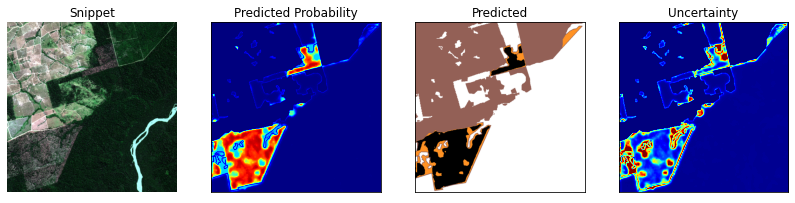

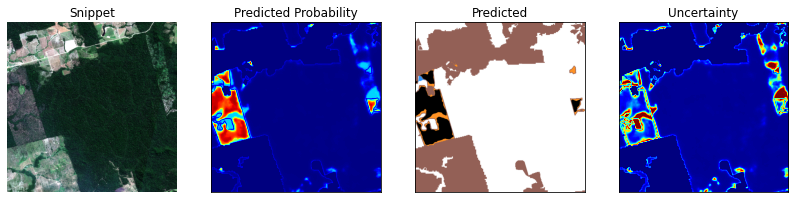

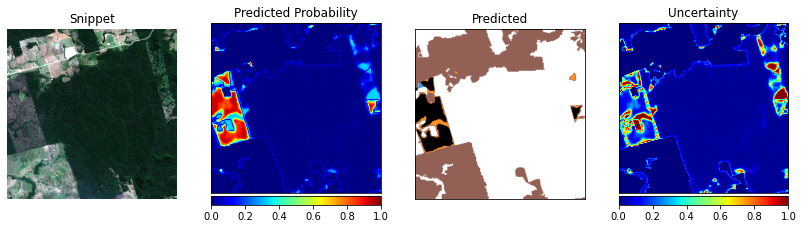

In [85]:
trainer.logger.plotCropSample(trainer)

In [86]:
trainer.logger.getStats(trainer.uncertainty)

ic| np.min(value): 0.010245735
    np.mean(value): 0.082735136
    np.max(value): 1.0


In [87]:
get_other_uncertainty_metrics = True
if get_other_uncertainty_metrics == True:
    trainer.getOtherUncertaintyMetrics()
    print(trainer.sUEO)

    print(trainer.ece_score)  

(54118385,) (54118385,)
0.2527536906326549
0.07123162650747099
0.2527536906326549
0.07123162650747099


In [88]:
# trainer.getUncertaintyMetrics()

In [89]:
# trainer.m

In [90]:
print(trainer.uncertainty.shape, trainer.predicted_test.shape)
print(trainer.uncertainty.dtype, trainer.predicted_test.dtype)
print(np.unique(trainer.predicted_test))
print(trainer.label_mask_current_deforestation_test.shape)


(54118385,) (54118385,)
float32 float32
[0. 1.]
(54118385,)


In [91]:
trainer.mean_prob[trainer.mask_amazon_ts == 1].shape

(81558000,)

In [92]:
uncertainty_test_correct = trainer.uncertainty[trainer.predicted_test == trainer.label_mask_current_deforestation_test]
uncertainty_test_incorrect = trainer.uncertainty[trainer.predicted_test != trainer.label_mask_current_deforestation_test]

predicted_test_correct = trainer.uncertainty[trainer.predicted_test == trainer.label_mask_current_deforestation_test]
uncertainty_test_incorrect = trainer.uncertainty[trainer.predicted_test != trainer.label_mask_current_deforestation_test]


In [93]:
print(np.min(uncertainty_test_correct), np.mean(uncertainty_test_correct), np.max(uncertainty_test_correct))
print(np.min(uncertainty_test_incorrect), np.mean(uncertainty_test_incorrect), np.max(uncertainty_test_incorrect))


0.010245735 0.07926442 1.0
0.014579692 0.7157656 1.0


In [94]:
trainer.alpha_reconstructed.shape

(17760, 9216, 3)

In [95]:
trainer.alpha_unpad = trainer.alpha_reconstructed[:trainer.label_mask.shape[0], :trainer.label_mask.shape[1]]

In [96]:
trainer.alpha_unpad.shape

(17730, 9200, 3)

In [97]:
print(np.min(trainer.alpha_unpad), np.mean(trainer.alpha_unpad), np.max(trainer.alpha_unpad))

1.0 31.301088 297.866


In [98]:
trainer.predicted_unpad.shape

(17730, 9200)

In [99]:
trainer.label_mask.shape

(17730, 9200)

In [100]:
'''
fig = plt.figure(figsize=(20,20))


plt.imshow(trainer.alpha_unpad.astype(np.uint8))
plt.plot(6600, 16500, marker='v', color="white")
plt.plot(5600, 16500, marker='v', color="white")
plt.plot(4600, 16500, marker='v', color="white")
'''

'\nfig = plt.figure(figsize=(20,20))\n\n\nplt.imshow(trainer.alpha_unpad.astype(np.uint8))\nplt.plot(6600, 16500, marker=\'v\', color="white")\nplt.plot(5600, 16500, marker=\'v\', color="white")\nplt.plot(4600, 16500, marker=\'v\', color="white")\n'

Reference 0
Predicted 0.0
Evidence [151.26576   0.        0.     ]
Alpha [152.26576   1.        1.     ]
trimesh.x [0.         1.         0.5        ... 0.50390625 0.50195312 0.49804688]
trimesh.y [0.         0.         0.8660254  ... 0.28416459 0.29431332 0.2875475 ]
xy2bc(xy) [1. 0. 0.]
pvals [22986.75641665612, 0.0, 0.0, 6.800105221370293e-42, 0.0, 6.800105221370293e-42, 2.9450601778129464e-15, 0.0, 1.9814533623983211e-87, 1.9814533623984207e-87, 1.9814533623983542e-87, 2.9450601778129464e-15, 1.9814533623983542e-87, 0.0, 6.800105221370521e-42, 3.9432230364668386e-05, 3.1022916776962224e-27, 3.1022916776962224e-27, 0.0, 8.581483965062887e-61, 5.7736715823475355e-133, 5.7736715823472454e-133, 0.0, 1.9814533623983542e-87, 8.581483965062503e-61, 5.7736715823475355e-133, 6.800105221370293e-42, 1.9814533623983542e-87, 3.1022916776963057e-27, 1.9814533623983542e-87, 5.7736715823475355e-133, 8.581483965062503e-61, 3.9432230364668386e-05, 3.1022916776962224e-27, 2.9450601778129464e-15, 5.77

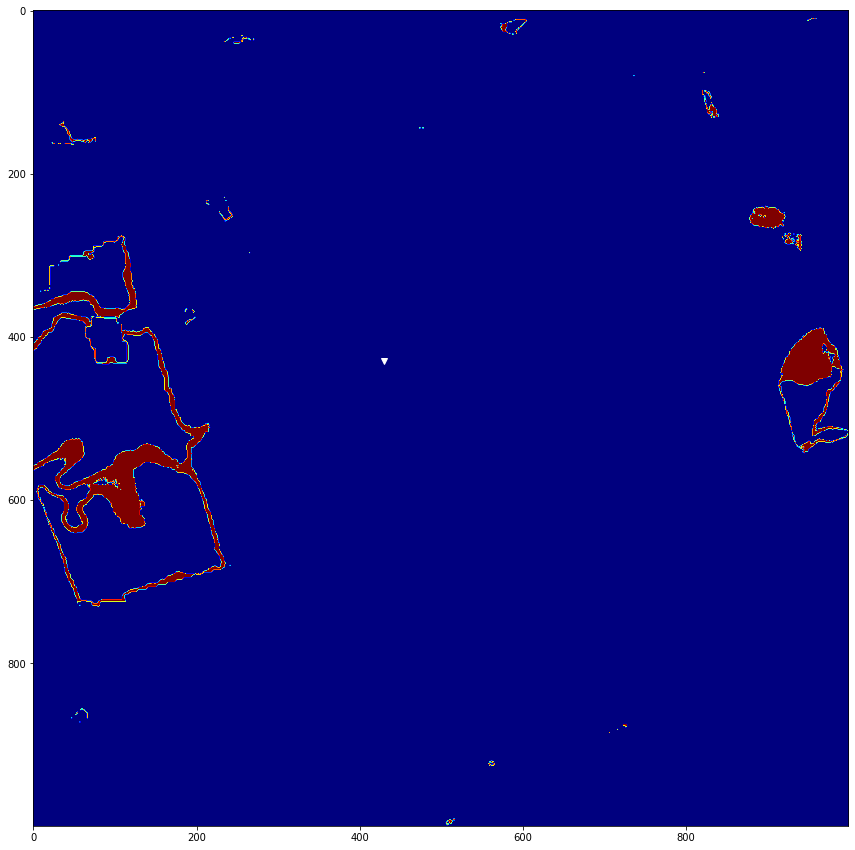

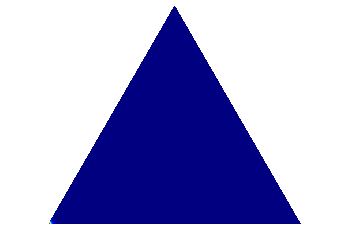

In [101]:
# lims = dataset.previewLims1
lims = dataset.previewLims2

# im = trainer.alpha_unpad[lims[0]:lims[1], lims[2]:lims[3]]
im = trainer.uncertainty_map[lims[0]:lims[1], lims[2]:lims[3]]
plt.figure(figsize=(15,15))
plt.imshow(im.astype(np.uint8), cmap='jet')

# row, col = (550, 550) # high evidence in class 0
# row, col = (200, 600) # class 1 is higher but it has high uncertainty
# row, col = (207, 617) # class 1 is higher but it has high uncertainty
row, col = (800, 200) # high evidence in class 1
# row, col = (200, 605) # alpha 1, 1, 1

row, col = (430, 950) # alpha 1, 1, 1
row, col = (430, 430) # alpha 1, 1, 1

plt.plot(col, row, marker='v', color="white")

plt.figure()
print("Reference",trainer.label_mask[lims[0]:lims[1], lims[2]:lims[3]][row, col])
print("Predicted",trainer.predicted_unpad[lims[0]:lims[1], lims[2]:lims[3]][row, col])
print("Evidence", trainer.alpha_unpad[lims[0]:lims[1], lims[2]:lims[3]][row, col] - 1)
print("Alpha", trainer.alpha_unpad[lims[0]:lims[1], lims[2]:lims[3]][row, col])

trainer.getMassFcn(trainer.alpha_unpad[lims[0]:lims[1], lims[2]:lims[3]][row, col])


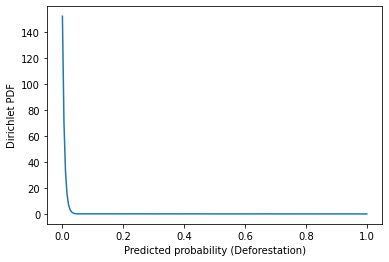

In [102]:
trainer.getMassFcn2D(trainer.alpha_unpad[lims[0]:lims[1], lims[2]:lims[3]][row, col][:2])


In [103]:


trainer.getPOIValues()


[{'snippet_id': 0,
  'coords': [550, 550],
  'reference': 0,
  'predicted': 0.0,
  'alpha': array([181.64474,   1.     ,   1.     ], dtype=float32)},
 {'snippet_id': 0,
  'coords': [210, 610],
  'reference': 1,
  'predicted': 0.0,
  'alpha': array([1., 1., 1.], dtype=float32)},
 {'snippet_id': 0,
  'coords': [207, 617],
  'reference': 1,
  'predicted': 0.0,
  'alpha': array([1., 1., 1.], dtype=float32)},
 {'snippet_id': 0,
  'coords': [800, 200],
  'reference': 1,
  'predicted': 1.0,
  'alpha': array([1.    , 5.7502, 1.    ], dtype=float32)},
 {'snippet_id': 1,
  'coords': [550, 115],
  'reference': 1,
  'predicted': 0.0,
  'alpha': array([1., 1., 1.], dtype=float32)},
 {'snippet_id': 1,
  'coords': [430, 950],
  'reference': 0,
  'predicted': 0.0,
  'alpha': array([1., 1., 1.], dtype=float32)}]

In [104]:
'''
lims = dataset.previewLims1

coords = {
    "snippet_id0": [
        [550, 550], # 10,1 alpha
        [210, 610], #harder 1,1 alpha
        [207, 617], # easy 1,1 alpha
        [800, 200] # easy 1,10 alpha
    ],
    "snippet_id1": [
        [550, 115], # 10,1 alpha # I think will diverge from ensemble
        [430, 950] # Will diverge from ensemble
    ]
}

poi_alpha_info = []
for coord in coords["snippet_id0"]:
    poi_alpha_info.append(
        {"snippet_id": 0,
            "coords": coord, # 10,1 alpha
               "reference": trainer.label_mask[lims[0]:lims[1], lims[2]:lims[3]][coord[0], coord[1]],
               "predicted": trainer.predicted_unpad[lims[0]:lims[1], lims[2]:lims[3]][coord[0], coord[1]],
               "alpha": trainer.alpha_unpad[lims[0]:lims[1], lims[2]:lims[3]][coord[0], coord[1]]}
    )

poi_alpha_info
lims = dataset.previewLims2

poi_alpha_info2 = []
for coord in coords["snippet_id1"]:
    poi_alpha_info2.append(
        {"snippet_id": 1,
            "coords": coord, # 10,1 alpha
               "reference": trainer.label_mask[lims[0]:lims[1], lims[2]:lims[3]][coord[0], coord[1]],
               "predicted": trainer.predicted_unpad[lims[0]:lims[1], lims[2]:lims[3]][coord[0], coord[1]],
               "alpha": trainer.alpha_unpad[lims[0]:lims[1], lims[2]:lims[3]][coord[0], coord[1]]}
    )

poi_alpha_info.extend(poi_alpha_info2)
'''

'\nlims = dataset.previewLims1\n\ncoords = {\n    "snippet_id0": [\n        [550, 550], # 10,1 alpha\n        [210, 610], #harder 1,1 alpha\n        [207, 617], # easy 1,1 alpha\n        [800, 200] # easy 1,10 alpha\n    ],\n    "snippet_id1": [\n        [550, 115], # 10,1 alpha # I think will diverge from ensemble\n        [430, 950] # Will diverge from ensemble\n    ]\n}\n\npoi_alpha_info = []\nfor coord in coords["snippet_id0"]:\n    poi_alpha_info.append(\n        {"snippet_id": 0,\n            "coords": coord, # 10,1 alpha\n               "reference": trainer.label_mask[lims[0]:lims[1], lims[2]:lims[3]][coord[0], coord[1]],\n               "predicted": trainer.predicted_unpad[lims[0]:lims[1], lims[2]:lims[3]][coord[0], coord[1]],\n               "alpha": trainer.alpha_unpad[lims[0]:lims[1], lims[2]:lims[3]][coord[0], coord[1]]}\n    )\n\npoi_alpha_info\nlims = dataset.previewLims2\n\npoi_alpha_info2 = []\nfor coord in coords["snippet_id1"]:\n    poi_alpha_info2.append(\n        {"

In [106]:
# trainer.getMassFcn(trainer.alpha_reconstructed[2500,7300])
# trainer.getMassFcn(trainer.alpha_unpad[16500,6600])


In [107]:
# trainer.m

In [108]:
trainer.getUncertaintyAAValues()

ic| self.uncertainty.shape: (54118385,)
    self.label_mask_current_deforestation_test.shape: (54118385,)


[0.13, 0.15, 0.2, 0.225, 0.25, 0.27, 0.3, 0.34, 0.36, 0.45, 0.55, 0.65, 0.8]
threshold 0.13


ic| label_current_deforestation_test_classified_incorrect.shape: (6346786,)
    predicted_test_classified_incorrect.shape: (6346786,)
ic| TP_H + FN_H + FP_H + TN_H: 6346786
    len(label_mask_current_deforestation_test): 54118385
ic| TP_H + FN_H + FP_H + TN_H: 6346786
    len(label_mask_current_deforestation_test): 54118385


[0.9940272  0.78937507 0.11937808 0.11727597 0.92483079 0.61219447
 0.04258718]
threshold 0.15


ic| label_current_deforestation_test_classified_incorrect.shape: (5966554,)
    predicted_test_classified_incorrect.shape: (5966554,)
ic| TP_H + FN_H + FP_H + TN_H: 5966554
    len(label_mask_current_deforestation_test): 54118385
ic| TP_H + FN_H + FP_H + TN_H: 5966554
    len(label_mask_current_deforestation_test): 54118385


[0.99209359 0.81171934 0.15648224 0.11025004 0.92044487 0.59773879
 0.04465681]
threshold 0.2


ic| label_current_deforestation_test_classified_incorrect.shape: (5219616,)
    predicted_test_classified_incorrect.shape: (5219616,)
ic| TP_H + FN_H + FP_H + TN_H: 5219616
    len(label_mask_current_deforestation_test): 54118385
ic| TP_H + FN_H + FP_H + TN_H: 5219616
    len(label_mask_current_deforestation_test): 54118385


[0.98599385 0.85004937 0.25691468 0.09644811 0.90673121 0.54756977
 0.04934459]
threshold 0.225


ic| label_current_deforestation_test_classified_incorrect.shape: (4918730,)
    predicted_test_classified_incorrect.shape: (4918730,)
ic| TP_H + FN_H + FP_H + TN_H: 4918730
    len(label_mask_current_deforestation_test): 54118385
ic| TP_H + FN_H + FP_H + TN_H: 4918730
    len(label_mask_current_deforestation_test): 54118385


[0.98357341 0.8592769  0.2982734  0.09088834 0.89973394 0.52186776
 0.05158779]
threshold 0.25


ic| label_current_deforestation_test_classified_incorrect.shape: (4652822,)
    predicted_test_classified_incorrect.shape: (4652822,)
ic| TP_H + FN_H + FP_H + TN_H: 4652822
    len(label_mask_current_deforestation_test): 54118385
ic| TP_H + FN_H + FP_H + TN_H: 4652822
    len(label_mask_current_deforestation_test): 54118385


[0.98179832 0.86466963 0.33345562 0.08597489 0.89258406 0.49732505
 0.05376616]
threshold 0.27


ic| label_current_deforestation_test_classified_incorrect.shape: (4461950,)
    predicted_test_classified_incorrect.shape: (4461950,)
ic| TP_H + FN_H + FP_H + TN_H: 4461950
    len(label_mask_current_deforestation_test): 54118385
ic| TP_H + FN_H + FP_H + TN_H: 4461950
    len(label_mask_current_deforestation_test): 54118385


[0.98016731 0.86713317 0.35606172 0.08244795 0.88782835 0.48004292
 0.055464  ]
threshold 0.3


ic| label_current_deforestation_test_classified_incorrect.shape: (4199263,)
    predicted_test_classified_incorrect.shape: (4199263,)
ic| TP_H + FN_H + FP_H + TN_H: 4199263
    len(label_mask_current_deforestation_test): 54118385
ic| TP_H + FN_H + FP_H + TN_H: 4199263
    len(label_mask_current_deforestation_test): 54118385


[0.97773663 0.86952882 0.38529605 0.07759402 0.88127517 0.45555351
 0.05801825]
threshold 0.34


ic| label_current_deforestation_test_classified_incorrect.shape: (3879563,)
    predicted_test_classified_incorrect.shape: (3879563,)
ic| TP_H + FN_H + FP_H + TN_H: 3879563
    len(label_mask_current_deforestation_test): 54118385
ic| TP_H + FN_H + FP_H + TN_H: 3879563
    len(label_mask_current_deforestation_test): 54118385


[0.97343386 0.87150512 0.4192312  0.0716866  0.87459821 0.42346164
 0.0614242 ]
threshold 0.36


ic| label_current_deforestation_test_classified_incorrect.shape: (3730150,)
    predicted_test_classified_incorrect.shape: (3730150,)
ic| TP_H + FN_H + FP_H + TN_H: 3730150
    len(label_mask_current_deforestation_test): 54118385
ic| TP_H + FN_H + FP_H + TN_H: 3730150
    len(label_mask_current_deforestation_test): 54118385


[0.97112425 0.87215923 0.43445889 0.06892574 0.87196456 0.40754692
 0.06316249]
threshold 0.45


ic| label_current_deforestation_test_classified_incorrect.shape: (3120630,)
    predicted_test_classified_incorrect.shape: (3120630,)
ic| TP_H + FN_H + FP_H + TN_H: 3120630
    len(label_mask_current_deforestation_test): 54118385
ic| TP_H + FN_H + FP_H + TN_H: 3120630
    len(label_mask_current_deforestation_test): 54118385


[0.95984614 0.8719558  0.49257301 0.05766303 0.86759624 0.33651732
 0.07125713]
threshold 0.55


ic| label_current_deforestation_test_classified_incorrect.shape: (2515642,)
    predicted_test_classified_incorrect.shape: (2515642,)
ic| TP_H + FN_H + FP_H + TN_H: 2515642
    len(label_mask_current_deforestation_test): 54118385
ic| TP_H + FN_H + FP_H + TN_H: 2515642
    len(label_mask_current_deforestation_test): 54118385


[0.9505691  0.86972556 0.54041349 0.04648406 0.86908929 0.26034346
 0.08300993]
threshold 0.65


ic| label_current_deforestation_test_classified_incorrect.shape: (1967397,)
    predicted_test_classified_incorrect.shape: (1967397,)
ic| TP_H + FN_H + FP_H + TN_H: 1967397
    len(label_mask_current_deforestation_test): 54118385
ic| TP_H + FN_H + FP_H + TN_H: 1967397
    len(label_mask_current_deforestation_test): 54118385


[0.94323707 0.86812044 0.58610616 0.03635358 0.87319741 0.1627906
 0.09925586]
threshold 0.8


ic| label_current_deforestation_test_classified_incorrect.shape: (1329288,)
    predicted_test_classified_incorrect.shape: (1329288,)
d:\Jorge\deforestation_uncertainty\src\metrics.py:296: RuntimeWarning: invalid value encountered in longlong_scalars
  precision_H = TP_H / (TP_H + FP_H)
ic| TP_H + FN_H + FP_H + TN_H: 1329288
    len(label_mask_current_deforestation_test): 54118385
ic| TP_H + FN_H + FP_H + TN_H: 1329288
    len(label_mask_current_deforestation_test): 54118385


[0.93701685 0.8237986  0.63898969 0.0245626         nan 0.
 0.11220845]


In [109]:
trainer.getUncertaintyAAAuditedValues()

ic| self.uncertainty.shape: (54118385,)
    self.label_mask_current_deforestation_test.shape: (54118385,)


threshold 0.13
(54118385,) (54118385,)
cm_audited [[53387350      524]
 [   23269   707242]]
[0.99925964 0.96814695]
threshold 0.15
(54118385,) (54118385,)
cm_audited [[53386963      911]
 [   26515   703996]]
[0.99870763 0.96370349]
threshold 0.2
(54118385,) (54118385,)
cm_audited [[53385208     2666]
 [   33107   697404]]
[0.99619181 0.95467967]
threshold 0.225
(54118385,) (54118385,)
cm_audited [[53384235     3639]
 [   35684   694827]]
[0.99479001 0.951152  ]
threshold 0.25
(54118385,) (54118385,)
cm_audited [[53383358     4516]
 [   38125   692386]]
[0.99351989 0.94781051]
threshold 0.27
(54118385,) (54118385,)
cm_audited [[53382611     5263]
 [   39855   690656]]
[0.99243734 0.9454423 ]
threshold 0.3
(54118385,) (54118385,)
cm_audited [[53381465     6409]
 [   42233   688278]]
[0.99077426 0.94218704]
threshold 0.34
(54118385,) (54118385,)
cm_audited [[53379516     8358]
 [   45154   685357]]
[0.98795182 0.93818847]
threshold 0.36
(54118385,) (54118385,)
cm_audited [[53378437     

ic| metric_values_audited: array([[0.99925964, 0.96814695],
                                  [0.99870763, 0.96370349],
                                  [0.99619181, 0.95467967],
                                  [0.99479001, 0.951152  ],
                                  [0.99351989, 0.94781051],
                                  [0.99243734, 0.9454423 ],
                                  [0.99077426, 0.94218704],
                                  [0.98795182, 0.93818847],
                                  [0.98639078, 0.93631718],
                                  [0.97826984, 0.92766707],
                                  [0.97032983, 0.91905255],
                                  [0.96272463, 0.91096233],
                                  [0.95260752, 0.86332718]])


cm_audited [[53356498    31376]
 [   99841   630670]]
[0.95260752 0.86332718]


In [110]:
trainer.setPlotLimsForUncertaintyAA()

In [111]:

def plotUncertaintyAA(self):

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
    fig.set_figheight(5)
    fig.set_figwidth(15)
    ax1.plot(self.m['AA']*100, self.m['precision_L']*100, 'C3-', label="Precision Low Uncertainty")
    ax1.plot(self.m['AA']*100, self.m['recall_L']*100, 'C3--', label="Recall Low Uncertainty")
    ax1.plot(self.m['AA']*100, self.m['precision_H']*100, 'C0-', label="Precision High Uncertainty")
    ax1.plot(self.m['AA']*100, self.m['recall_H']*100, 'C0--', label="Recall High Uncertainty")
    ax1.plot(self.m['AA']*100, self.m_audited['precision']*100, 'C2-', label="Precision Audited")
    ax1.plot(self.m['AA']*100, self.m_audited['recall']*100, 'C2--', label="Recall Audited")

    ax1.legend(loc="lower right")
    ax1.set_ylabel('Precision/recall (%)')
    ax1.set_xlabel('Audit Area (%)')
    ax1.set_ylim(self.ylim)
    ax1.set_xlim(self.xlim)
    ax1.grid()

    xs = [0, 120]
    ax1.vlines(x = 3, ymin = 0, ymax = max(xs),
            colors = (0.2, 0.2, 0.2),
            label = 'vline_multiple - full height')

    ax2.plot(range(int(self.xlim[0]), int(self.xlim[1] + 2)), 
        np.ones(int(self.xlim[1] + 2)) * self.f1, 
        'C1:', label="F1 No Uncertainty")

    ax2.plot(self.m['AA']*100, self.m['f1_L']*100, 'C3-', label="F1 Low Uncertainty")
    ax2.plot(self.m['AA']*100, self.m['f1_H']*100, 'C0-', label="F1 High Uncertainty")
    ax2.plot(self.m['AA']*100, self.m_audited['f1']*100, 'C2-', label="F1 Audited")

    ax2.legend(loc="lower right")
    ax2.set_ylabel('F1 score (%)')
    ax2.set_xlabel('Audit Area (%)')
    ax2.set_ylim(self.ylim)
    ax2.set_xlim(self.xlim)

    ax2.grid()

    xs = [0, 120]
    ax2.vlines(x = 3, ymin = 0, ymax = max(xs),
            colors = (0.2, 0.2, 0.2),
            label = '3% AA')

    ax3.plot(np.asarray(self.threshold_list), self.m['AA']*100, label="AA")
    ax3.set_ylabel('Audit Area (%)')
    ax3.set_xlabel('Uncertainty Threshold')
    ax3.grid()
    ax3.set_ylim(self.xlim)

    self.xlim_adjusted = ax3.get_xlim()
    ax3.hlines(y = 3, xmin = self.xlim_adjusted[0], xmax = self.xlim_adjusted[1],
            colors = (0.2, 0.2, 0.2),
            label = '3% AA')

    ax3.set_xlim(self.xlim_adjusted)

    # if save_figures == True:
    if True:
        plt.savefig('output/figures/recall_precision_f1_AA.png', dpi=150, bbox_inches='tight')

def plotUEO(self): 

    plt.plot(self.m['AA']*100, self.m['UEO'], label="UEO") 
    plt.grid() 
    plt.xlabel('Audit Area (%)') 
    plt.ylabel('UEO (%)') 
    plt.xlim(self.xlim)
    plt.ylim([0, 0.4])

import types

trainer.plotUncertaintyAA = types.MethodType(plotUncertaintyAA, trainer)
trainer.plotUEO = types.MethodType(plotUEO, trainer)


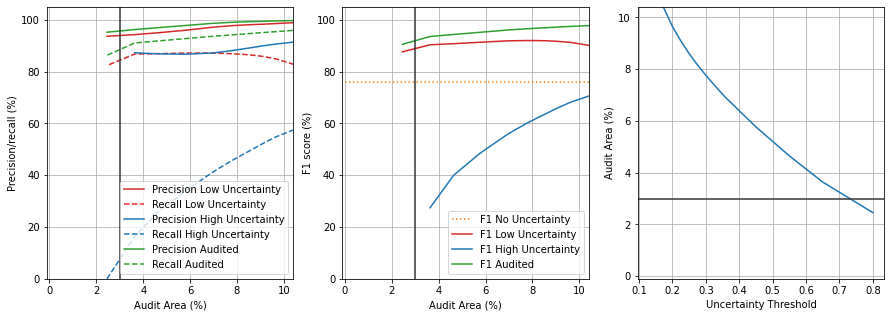

In [112]:
trainer.plotUncertaintyAA()

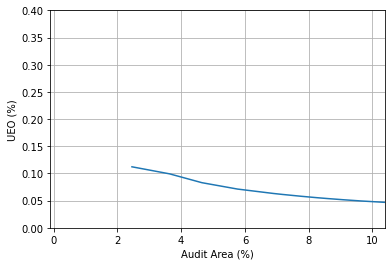

In [113]:
trainer.plotUEO()

In [114]:
trainer.getOptimalUncertaintyThreshold()

ic| bounds: (0.0015, 0.9985)
c:\Users\jchamorro\Anaconda3\envs\tf2\lib\site-packages\scipy\optimize\_minimize.py:783: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  warn("Method 'bounded' does not support relative tolerance in x; "


0.38232011321635484
threshold 0.38232011321635484


ic| label_current_deforestation_test_classified_incorrect.shape: (3570163,)
    predicted_test_classified_incorrect.shape: (3570163,)
ic| TP_H + FN_H + FP_H + TN_H: 3570163
    len(label_mask_current_deforestation_test): 54118385
ic| TP_H + FN_H + FP_H + TN_H: 3570163
    len(label_mask_current_deforestation_test): 54118385


[0.9682591  0.87241278 0.45057501 0.0659695  0.86989414 0.38966492
 0.0650772 ]
0.6176798867836452
threshold 0.6176798867836452


ic| label_current_deforestation_test_classified_incorrect.shape: (2136582,)
    predicted_test_classified_incorrect.shape: (2136582,)
ic| TP_H + FN_H + FP_H + TN_H: 2136582
    len(label_mask_current_deforestation_test): 54118385
ic| TP_H + FN_H + FP_H + TN_H: 2136582
    len(label_mask_current_deforestation_test): 54118385


[0.94554617 0.86833211 0.57045411 0.03947978 0.87157704 0.19978531
 0.09349438]
0.7631402264327096
threshold 0.7631402264327096


ic| label_current_deforestation_test_classified_incorrect.shape: (1486861,)
    predicted_test_classified_incorrect.shape: (1486861,)
d:\Jorge\deforestation_uncertainty\src\metrics.py:296: RuntimeWarning: invalid value encountered in longlong_scalars
  precision_H = TP_H / (TP_H + FP_H)
ic| TP_H + FN_H + FP_H + TN_H: 1486861
    len(label_mask_current_deforestation_test): 54118385
ic| TP_H + FN_H + FP_H + TN_H: 1486861
    len(label_mask_current_deforestation_test): 54118385


[0.93701685 0.85512694 0.63898969 0.02747423        nan 0.
 0.11559369]
0.8310109215445316
threshold 0.8310109215445316


ic| label_current_deforestation_test_classified_incorrect.shape: (1186319,)
    predicted_test_classified_incorrect.shape: (1186319,)
d:\Jorge\deforestation_uncertainty\src\metrics.py:296: RuntimeWarning: invalid value encountered in longlong_scalars
  precision_H = TP_H / (TP_H + FP_H)
ic| TP_H + FN_H + FP_H + TN_H: 1186319
    len(label_mask_current_deforestation_test): 54118385
ic| TP_H + FN_H + FP_H + TN_H: 1186319
    len(label_mask_current_deforestation_test): 54118385


[0.93701685 0.80018685 0.63898969 0.02192081        nan 0.
 0.11029443]
0.7297476631124618
threshold 0.7297476631124618


ic| label_current_deforestation_test_classified_incorrect.shape: (1619753,)
    predicted_test_classified_incorrect.shape: (1619753,)
ic| TP_H + FN_H + FP_H + TN_H: 1619753
    len(label_mask_current_deforestation_test): 54118385
ic| TP_H + FN_H + FP_H + TN_H: 1619753
    len(label_mask_current_deforestation_test): 54118385


[0.93837602 0.86766675 0.62787008 0.02992981 0.86617616 0.04023458
 0.1133968 ]
0.6869415815984747
threshold 0.6869415815984747


ic| label_current_deforestation_test_classified_incorrect.shape: (1795343,)
    predicted_test_classified_incorrect.shape: (1795343,)
ic| TP_H + FN_H + FP_H + TN_H: 1795343
    len(label_mask_current_deforestation_test): 54118385
ic| TP_H + FN_H + FP_H + TN_H: 1795343
    len(label_mask_current_deforestation_test): 54118385


[0.94084169 0.86788647 0.60490123 0.03317436 0.87396905 0.1124965
 0.10582291]
0.727261299891792
threshold 0.727261299891792


ic| label_current_deforestation_test_classified_incorrect.shape: (1629464,)
    predicted_test_classified_incorrect.shape: (1629464,)
ic| TP_H + FN_H + FP_H + TN_H: 1629464
    len(label_mask_current_deforestation_test): 54118385
ic| TP_H + FN_H + FP_H + TN_H: 1629464
    len(label_mask_current_deforestation_test): 54118385


[0.93851403 0.8676707  0.62650939 0.03010925 0.86754211 0.0449027
 0.11294736]
0.7316623382442138
threshold 0.7316623382442138


ic| label_current_deforestation_test_classified_incorrect.shape: (1612287,)
    predicted_test_classified_incorrect.shape: (1612287,)
ic| TP_H + FN_H + FP_H + TN_H: 1612287
    len(label_mask_current_deforestation_test): 54118385
ic| TP_H + FN_H + FP_H + TN_H: 1612287
    len(label_mask_current_deforestation_test): 54118385


[0.9382322  0.86764814 0.62895288 0.02979185 0.86666667 0.03648342
 0.11372277]
0.7288983871701384
threshold 0.7288983871701384


ic| label_current_deforestation_test_classified_incorrect.shape: (1623034,)
    predicted_test_classified_incorrect.shape: (1623034,)
ic| TP_H + FN_H + FP_H + TN_H: 1623034
    len(label_mask_current_deforestation_test): 54118385
ic| TP_H + FN_H + FP_H + TN_H: 1623034
    len(label_mask_current_deforestation_test): 54118385


[0.93843054 0.86767022 0.62744024 0.02999044 0.86613284 0.04171467
 0.11324484]
0.7286521266760432
threshold 0.7286521266760432


ic| label_current_deforestation_test_classified_incorrect.shape: (1624005,)
    predicted_test_classified_incorrect.shape: (1624005,)
ic| TP_H + FN_H + FP_H + TN_H: 1624005
    len(label_mask_current_deforestation_test): 54118385
ic| TP_H + FN_H + FP_H + TN_H: 1624005
    len(label_mask_current_deforestation_test): 54118385


[0.93843192 0.86766869 0.6272883  0.03000838 0.86693712 0.04223696
 0.11319656]
0.7287356841791585
threshold 0.7287356841791585


ic| label_current_deforestation_test_classified_incorrect.shape: (1623676,)
    predicted_test_classified_incorrect.shape: (1623676,)
ic| TP_H + FN_H + FP_H + TN_H: 1623676
    len(label_mask_current_deforestation_test): 54118385
ic| TP_H + FN_H + FP_H + TN_H: 1623676
    len(label_mask_current_deforestation_test): 54118385


[0.93843044 0.86767064 0.62733484 0.0300023  0.86674132 0.04207686
 0.11321364]
0.7287702124332615
threshold 0.7287702124332615


ic| label_current_deforestation_test_classified_incorrect.shape: (1623552,)
    predicted_test_classified_incorrect.shape: (1623552,)
ic| TP_H + FN_H + FP_H + TN_H: 1623552
    len(label_mask_current_deforestation_test): 54118385
ic| TP_H + FN_H + FP_H + TN_H: 1623552
    len(label_mask_current_deforestation_test): 54118385


[0.93843297 0.86767565 0.62736222 0.03000001 0.86646945 0.04198217
 0.11322179]
0.7288191708262494
threshold 0.7288191708262494


ic| label_current_deforestation_test_classified_incorrect.shape: (1623358,)
    predicted_test_classified_incorrect.shape: (1623358,)
ic| TP_H + FN_H + FP_H + TN_H: 1623358
    len(label_mask_current_deforestation_test): 54118385
ic| TP_H + FN_H + FP_H + TN_H: 1623358
    len(label_mask_current_deforestation_test): 54118385
ic| self.threshold_optimal: 0.7287702124332615


[0.93843407 0.86767509 0.62739507 0.02999642 0.86623031 0.04186934
 0.11323131]


In [115]:
snapshot = tracemalloc.take_snapshot()
display_top(snapshot, limit=20)

Top 20 lines
#1: <__array_function__ internals>:5: 14022462.8 KiB
#2: ipykernel_18512\3510209264.py:3: 13380609.5 KiB
    trainer.image_stack = trainer.image_stack[..., trainer.patchesHandler.dataset.image_channels[-1]]
#3: cbook\__init__.py:701: 3380550.6 KiB
    x = np.array(x, subok=True, copy=copy)
#4: framework\constant_op.py:106: 2013988.9 KiB
    return ops.EagerTensor(value, ctx.device_name, dtype)
#5: src\patchesHandler.py:339: 1918080.1 KiB
    alpha_reconstructed = np.zeros((h, w, 3), dtype=np.float32)
#6: deforestation_uncertainty\utils_v1.py:416: 760693.7 KiB
    return vector_test[label_mask_test != 2]
#7: trainer\base.py:361: 639360.2 KiB
    self.uncertainty_to_show = self.uncertainty_map.copy()[:self.label_mask.shape[0], :self.label_mask.shape[1]]
#8: trainer\evidential.py:535: 639360.1 KiB
    self.prob_rec = prob_reconstructed.copy()
#9: src\patchesHandler.py:338: 639360.1 KiB
    u_reconstructed = np.zeros((h, w), dtype=np.float32)
#10: trainer\evidential.py:556: 63

In [116]:
trainer.getUncertaintyMetricsFromOptimalThreshold()

threshold 0.7287702124332615


ic| label_current_deforestation_test_classified_incorrect.shape: (1623552,)
    predicted_test_classified_incorrect.shape: (1623552,)
ic| TP_H + FN_H + FP_H + TN_H: 1623552
    len(label_mask_current_deforestation_test): 54118385
ic| TP_H + FN_H + FP_H + TN_H: 1623552
    len(label_mask_current_deforestation_test): 54118385


[0.93843297 0.86767565 0.62736222 0.03000001 0.86646945 0.04198217
 0.11322179]
threshold 0.7287702124332615
(54118385,) (54118385,)


ic| self.m_optimal: {'AA': array([0.03000001]),
                     'UEO': array([0.11322179]),
                     'f1': 75.98,
                     'f1_H': array([0.0800841]),
                     'f1_L': array([0.90166829]),
                     'precision_H': array([0.86646945]),
                     'precision_L': array([0.93843297]),
                     'recall_H': array([0.04198217]),
                     'recall_L': array([0.86767565]),
                     'recall_Ltotal': array([0.62736222])}
ic| self.m_audited_optimal: {'f1': array([0.92966563]),
                             'precision': array([0.95646792]),
                             'recall': array([0.90432451])}


cm_audited [[53357807    30067]
 [   69892   660619]]
[0.95646792 0.90432451]


{'metrics': {'precision_L': array([0.93843297]),
  'recall_L': array([0.86767565]),
  'recall_Ltotal': array([0.62736222]),
  'AA': array([0.03000001]),
  'precision_H': array([0.86646945]),
  'recall_H': array([0.04198217]),
  'UEO': array([0.11322179]),
  'f1_L': array([0.90166829]),
  'f1_H': array([0.0800841]),
  'f1': 75.98},
 'metrics_audited': {'precision': array([0.95646792]),
  'recall': array([0.90432451]),
  'f1': array([0.92966563])},
 'exp': 196}